In [1]:
# from future import annotations

from IPython.display import Image, display
from typing import List, Optional, TypedDict
from langgraph.graph import StateGraph, END, START
from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

### 1) A structured Plan schema (so the model reasons in a controllable, non-freeform way)

In [2]:
class Step(BaseModel):
    id: str
    description: str
    rationale: Optional[str] = None

class Plan(BaseModel):
    objective: str
    steps: List[Step]
    assumptions: List[str] = []
    risks: List[str] = []
    success_criteria: List[str] = []

### 2) Graph state

In [3]:
class AgentState(TypedDict, total=False):
    # user input
    input: str
    # internal reasoning product (not shown to end user by default)
    plan: Plan
    # final answer to return
    final: str

### 3) LLMs (you can use a single model; here we separate planner and solver for clarity)

In [4]:
planner_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)
solver_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)

### 4) Nodes

In [5]:
def analyze(state: AgentState) -> AgentState:
    """
    Create a structured plan (Plan) before doing anything.
    The model returns a JSON object conforming to the Plan schema.
    """
    system = SystemMessage(content=(
    "You are a careful planner. Analyze the user's request and produce a concise, actionable plan. "
    "Return ONLY valid JSON that matches the Plan schema. Do not include explanations."
    ))
    user = HumanMessage(content=state["input"])

    # Ask the model to return the Plan object directly (structured output)
    plan: Plan = planner_llm.with_structured_output(Plan).invoke([system, user])
    return {"plan": plan}

def answer(state: AgentState) -> AgentState:
    """
    Execute the plan and produce the final answer.
    The internal plan is used as a guide, but the final response should not reveal the plan explicitly.
    """
    plan = state["plan"]
    system = SystemMessage(content=(
    "You are a precise problem solver. Follow the provided plan internally. "
    "Do not reveal or restate the plan. Provide a clear, complete final answer to the user."
    ))

    # Give the model the user question and the plan as context.
    # The plan is given as JSON but we instruct the model NOT to reveal it.
    user = HumanMessage(content=(
        f"User request:\n{state['input']}\n\n"
        f"Internal plan (for your use, do not reveal to user):\n{plan.model_dump_json(indent=2)}"
    ))

    msg = solver_llm.invoke([system, user])
    return {"final": msg.content}

### 5) Build the graph

In [6]:
workflow = StateGraph(AgentState)
workflow.add_node("analyze", analyze)
workflow.add_node("answer", answer)

workflow.add_edge(START, "analyze")
workflow.add_edge("analyze", "answer")
workflow.add_edge("answer", END)

app = workflow.compile()

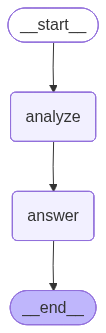

In [7]:
# View
display(Image(app.get_graph(xray=1).draw_mermaid_png()))

### 6) Example usage

In [9]:
# if __name__ == "main":
query = "Compare the pros and cons of RAG vs fine-tuning for adapting an LLM to a new domain, and give a short recommendation."
result = app.invoke({"input": query})

# If you want to inspect the internal plan for debugging:
# print("PLAN:\n", result.get("plan"))  # Note: avoid showing to end users

print("FINAL ANSWER:\n", result["final"])

FINAL ANSWER:
 ### Comparison of RAG vs Fine-Tuning for Domain Adaptation

| Aspect                     | Retrieval-Augmented Generation (RAG)                      | Fine-Tuning                                      |
|---------------------------|----------------------------------------------------------|-------------------------------------------------|
| **Pros**                  | - Combines retrieval with generation, enhancing accuracy. <br> - Can leverage external knowledge bases without extensive retraining. <br> - More adaptable to new information as it can pull from updated sources. <br> - Generally requires less data for effective adaptation. | - Tailors the model specifically to the target domain, improving performance. <br> - Can achieve high accuracy with sufficient domain-specific data. <br> - Fully integrates domain knowledge into the model's parameters. <br> - Suitable for specialized tasks where context is crucial. |
| **Cons**                  | - May require a robust r